# Import Liabaries

In [1]:
import os
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import (f1_score, accuracy_score, confusion_matrix, 
                             classification_report, precision_score, recall_score)
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Seed Everything

In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Hyperparameters 

In [3]:
seed = 42
batch_size = 64
epochs = 5
lr = 0.001
dropout_rate = 0.5

seed_everything(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device used: {device}")

Device used: cuda


# Data Loading

In [4]:
base_dir = '/kaggle/input/ai-vs-human-generated-dataset'
train_csv_path = os.path.join(base_dir, 'train.csv')
test_csv_path = os.path.join(base_dir, 'test.csv')

df_train = pd.read_csv(train_csv_path)
df_test = pd.read_csv(test_csv_path)

df_test['id'] = df_test['id'].apply(lambda x: os.path.join(base_dir, x))
df_train['file_name'] = df_train['file_name'].apply(lambda x: os.path.join(base_dir, x))

all_image_paths = df_train['file_name'].values
all_labels = df_train['label'].values

# Split: 70% train, 15% validation, 15% test
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.30, random_state=seed, stratify=all_labels
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.50, random_state=seed, stratify=temp_labels
)

print(f"Train Data: {len(train_paths)}")
print(f"Validation Data: {len(val_paths)}")
print(f"Test Data: {len(test_paths)}")

Train Data: 55965
Validation Data: 11992
Test Data: 11993


#  Data Transforms

In [5]:
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Data Sets

In [6]:
class ImageDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

# Create DataLoader

In [7]:
train_data = ImageDataset(train_paths, train_labels, transform=train_transforms)
val_data = ImageDataset(val_paths, val_labels, transform=val_test_transforms)
test_data = ImageDataset(test_paths, test_labels, transform=val_test_transforms)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

# CNN MODEL ARCHITECTURE

In [8]:
class SimpleCNN(nn.Module):
    """
    Custom CNN Architecture for Binary Image Classification
    
    Architecture:
    - Conv1: 32 filters, 5x5 kernel, ReLU activation
    - MaxPool1: 2x2
    - Conv2: 64 filters, 3x3 kernel, ReLU activation
    - MaxPool2: 2x2
    - Conv3: 128 filters, 3x3 kernel, ReLU activation
    - MaxPool3: 2x2
    - Flatten
    - FC1: 512 units, ReLU activation
    - Dropout: 0.5
    - Output: 2 units (binary classification), Softmax
    """
    def __init__(self, num_classes=2, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Flatten and fully connected layers
        self.flatten = nn.Flatten()
        
        # Calculate the size after convolutions and pooling
        # Input: 128x128 -> Conv1+Pool1: 64x64 -> Conv2+Pool2: 32x32 -> Conv3+Pool3: 16x16
        # 128 channels * 16 * 16 = 32768
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # First conv block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        # Second conv block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Third conv block
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        # Flatten and fully connected
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


#  INITIALIZE MODEL 

In [9]:
model = SimpleCNN(num_classes=2, dropout_rate=dropout_rate).to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2)

# LOSS AND OPTIMIZER

In [10]:
criterion = nn.CrossEntropyLoss()

# We'll compare three optimizers:
# 1. Adam (our main choice)
optimizer_adam = optim.Adam(model.parameters(), lr=lr)

# 2. SGD (for comparison)
optimizer_sgd = optim.SGD(model.parameters(), lr=lr)

# 3. SGD with Momentum (for comparison)
optimizer_sgd_momentum = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Choose Adam as the primary optimizer
optimizer = optimizer_adam
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

print(f"\nUsing optimizer: Adam")
print(f"Learning rate: {lr}")
print(f"Dropout rate: {dropout_rate}")


Using optimizer: Adam
Learning rate: 0.001
Dropout rate: 0.5


# TRAINING FUNCTION 

In [11]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    
    for data, label in tqdm(train_loader, desc="Training", leave=False):
        data, label = data.to(device), label.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        preds = output.argmax(dim=1)
        epoch_accuracy += (preds == label).float().mean().item()
    
    epoch_loss /= len(train_loader)
    epoch_accuracy /= len(train_loader)
    
    return epoch_loss, epoch_accuracy

# VALIDATION FUNCTION 

In [12]:
# ==================== VALIDATION FUNCTION ====================
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, label in tqdm(val_loader, desc="Validation", leave=False):
            data, label = data.to(device), label.to(device)
            output = model(data)
            loss = criterion(output, label)
            
            val_loss += loss.item()
            preds = output.argmax(dim=1)
            val_accuracy += (preds == label).float().mean().item()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)
    val_f1 = f1_score(all_labels, all_preds)
    
    return val_loss, val_accuracy, val_f1

# TRAINING LOOP

In [13]:

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_f1s = []

best_val_f1 = 0.0
best_model_path = "best_cnn_model.pth"

print("\n" + "="*60)
print("TRAINING STARTED")
print("="*60)

for epoch in range(epochs):
    print(f"\nEpoch [{epoch+1}/{epochs}]")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validate
    val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)
    
    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), best_model_path)
        print(f"✓ Best model saved! (F1: {val_f1:.4f})")
    
    # Step scheduler
    scheduler.step()

print("\n" + "="*60)
print("TRAINING COMPLETED")
print("="*60)



TRAINING STARTED

Epoch [1/5]


Train Loss: 0.5710 | Train Acc: 0.8030
Val Loss: 0.3911 | Val Acc: 0.8118 | Val F1: 0.8347
✓ Best model saved! (F1: 0.8347)

Epoch [2/5]


Train Loss: 0.4004 | Train Acc: 0.8306
Val Loss: 0.3579 | Val Acc: 0.8421 | Val F1: 0.8574
✓ Best model saved! (F1: 0.8574)

Epoch [3/5]


Train Loss: 0.3679 | Train Acc: 0.8477
Val Loss: 0.3039 | Val Acc: 0.8778 | Val F1: 0.8808
✓ Best model saved! (F1: 0.8808)

Epoch [4/5]


Train Loss: 0.3402 | Train Acc: 0.8623
Val Loss: 0.2657 | Val Acc: 0.8930 | Val F1: 0.8957
✓ Best model saved! (F1: 0.8957)

Epoch [5/5]


Train Loss: 0.3189 | Train Acc: 0.8729
Val Loss: 0.2950 | Val Acc: 0.8676 | Val F1: 0.8795

TRAINING COMPLETED


# PLOT TRAINING CURVES

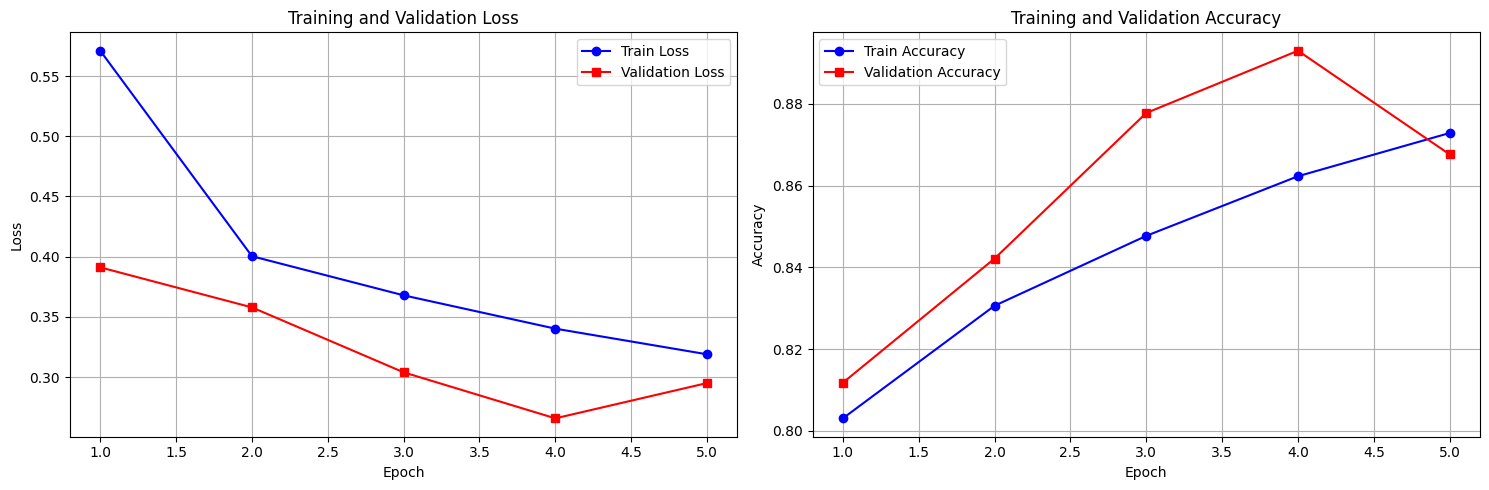


EVALUATING ON TEST SET


Testing: 100%|██████████| 188/188 [00:36<00:00,  5.08it/s]


In [14]:

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(range(1, epochs+1), train_losses, 'b-', label='Train Loss', marker='o')
axes[0].plot(range(1, epochs+1), val_losses, 'r-', label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(range(1, epochs+1), train_accuracies, 'b-', label='Train Accuracy', marker='o')
axes[1].plot(range(1, epochs+1), val_accuracies, 'r-', label='Validation Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================== EVALUATE ON TEST SET ====================
print("\n" + "="*60)
print("EVALUATING ON TEST SET")
print("="*60)

# Load best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for data, label in tqdm(test_loader, desc="Testing"):
        data, label = data.to(device), label.to(device)
        output = model(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())


 # EVALUATE ON TEST SET


EVALUATING ON TEST SET


Testing: 100%|██████████| 188/188 [00:24<00:00,  7.74it/s]



Test Accuracy: 0.8910
Test F1 Score: 0.8941
Test Precision: 0.8694
Test Recall: 0.9203

Classification Report:
              precision    recall  f1-score   support

       Human       0.92      0.86      0.89      5997
          AI       0.87      0.92      0.89      5996

    accuracy                           0.89     11993
   macro avg       0.89      0.89      0.89     11993
weighted avg       0.89      0.89      0.89     11993



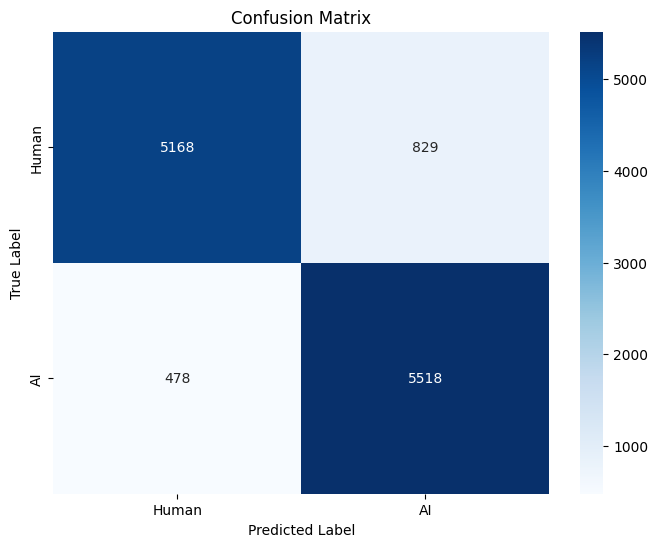


EVALUATION COMPLETED


In [15]:
print("\n" + "="*60)
print("EVALUATING ON TEST SET")
print("="*60)

# Load best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for data, label in tqdm(test_loader, desc="Testing"):
        data, label = data.to(device), label.to(device)
        output = model(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Calculate metrics
test_accuracy = accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds)
test_recall = recall_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Human', 'AI']))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("EVALUATION COMPLETED")
print("="*60)

# SUBMISSION

In [16]:
class TestDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(img_path)

kaggle_test_dataset = TestDataset(df_test['id'].values, transform=val_test_transforms)
kaggle_test_loader = DataLoader(kaggle_test_dataset, batch_size=batch_size, 
                                shuffle=False, num_workers=4)

predictions = []
image_names = []

model.eval()
with torch.no_grad():
    for data, names in tqdm(kaggle_test_loader, desc="Generating Kaggle Predictions"):
        data = data.to(device)
        outputs = model(data)
        preds = outputs.argmax(dim=1)
        predictions.extend(preds.cpu().numpy())
        image_names.extend([f"test_data_v2/{name}" for name in names])

submission_df = pd.DataFrame({
    'id': image_names,
    'label': predictions
})

submission_df.to_csv("cnn_submission.csv", index=False)
print("\n✓ Submission file generated: cnn_submission.csv")
print(f"Total predictions: {len(submission_df)}")

Generating Kaggle Predictions: 100%|██████████| 87/87 [00:58<00:00,  1.48it/s]


✓ Submission file generated: cnn_submission.csv
Total predictions: 5540


In [17]:
# import os
# import random
# import pandas as pd
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from PIL import Image
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import (f1_score, accuracy_score, confusion_matrix, 
#                              classification_report, precision_score, recall_score)
# from torch.optim.lr_scheduler import StepLR
# from torch.utils.data import DataLoader, Dataset
# from torchvision import transforms
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# import seaborn as sns

# # ==================== SEED EVERYTHING ====================
# def seed_everything(seed):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# # ==================== HYPERPARAMETERS ====================
# seed = 42
# batch_size = 64
# epochs = 5
# lr = 0.001
# dropout_rate = 0.5

# seed_everything(seed)
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(f"Device used: {device}")

# # ==================== DATA LOADING ====================
# base_dir = '/kaggle/input/ai-vs-human-generated-dataset'
# train_csv_path = os.path.join(base_dir, 'train.csv')
# test_csv_path = os.path.join(base_dir, 'test.csv')

# df_train = pd.read_csv(train_csv_path)
# df_test = pd.read_csv(test_csv_path)

# df_test['id'] = df_test['id'].apply(lambda x: os.path.join(base_dir, x))
# df_train['file_name'] = df_train['file_name'].apply(lambda x: os.path.join(base_dir, x))

# all_image_paths = df_train['file_name'].values
# all_labels = df_train['label'].values

# # Split: 70% train, 15% validation, 15% test
# train_paths, temp_paths, train_labels, temp_labels = train_test_split(
#     all_image_paths, all_labels, test_size=0.30, random_state=seed, stratify=all_labels
# )

# val_paths, test_paths, val_labels, test_labels = train_test_split(
#     temp_paths, temp_labels, test_size=0.50, random_state=seed, stratify=temp_labels
# )

# print(f"Train Data: {len(train_paths)}")
# print(f"Validation Data: {len(val_paths)}")
# print(f"Test Data: {len(test_paths)}")

# # ==================== DATA TRANSFORMS ====================
# train_transforms = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# val_test_transforms = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# # ==================== DATASET CLASS ====================
# class ImageDataset(Dataset):
#     def __init__(self, file_list, labels, transform=None):
#         self.file_list = file_list
#         self.labels = labels
#         self.transform = transform

#     def __len__(self):
#         return len(self.file_list)

#     def __getitem__(self, idx):
#         img_path = self.file_list[idx]
#         img = Image.open(img_path).convert("RGB")
#         if self.transform:
#             img = self.transform(img)
#         label = self.labels[idx]
#         return img, label

# # ==================== CREATE DATALOADERS ====================
# train_data = ImageDataset(train_paths, train_labels, transform=train_transforms)
# val_data = ImageDataset(val_paths, val_labels, transform=val_test_transforms)
# test_data = ImageDataset(test_paths, test_labels, transform=val_test_transforms)

# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

# # ==================== CNN MODEL ARCHITECTURE ====================
# class SimpleCNN(nn.Module):
#     """
#     Custom CNN Architecture for Binary Image Classification
    
#     Architecture:
#     - Conv1: 32 filters, 5x5 kernel, ReLU activation
#     - MaxPool1: 2x2
#     - Conv2: 64 filters, 3x3 kernel, ReLU activation
#     - MaxPool2: 2x2
#     - Conv3: 128 filters, 3x3 kernel, ReLU activation
#     - MaxPool3: 2x2
#     - Flatten
#     - FC1: 512 units, ReLU activation
#     - Dropout: 0.5
#     - Output: 2 units (binary classification), Softmax
#     """
#     def __init__(self, num_classes=2, dropout_rate=0.5):
#         super(SimpleCNN, self).__init__()
        
#         # Convolutional layers
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.relu1 = nn.ReLU()
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.relu2 = nn.ReLU()
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         self.bn3 = nn.BatchNorm2d(128)
#         self.relu3 = nn.ReLU()
#         self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
#         # Flatten and fully connected layers
#         self.flatten = nn.Flatten()
        
#         # Calculate the size after convolutions and pooling
#         # Input: 128x128 -> Conv1+Pool1: 64x64 -> Conv2+Pool2: 32x32 -> Conv3+Pool3: 16x16
#         # 128 channels * 16 * 16 = 32768
#         self.fc1 = nn.Linear(128 * 16 * 16, 512)
#         self.relu4 = nn.ReLU()
#         self.dropout = nn.Dropout(p=dropout_rate)
#         self.fc2 = nn.Linear(512, num_classes)
        
#     def forward(self, x):
#         # First conv block
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu1(x)
#         x = self.pool1(x)
        
#         # Second conv block
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.relu2(x)
#         x = self.pool2(x)
        
#         # Third conv block
#         x = self.conv3(x)
#         x = self.bn3(x)
#         x = self.relu3(x)
#         x = self.pool3(x)
        
#         # Flatten and fully connected
#         x = self.flatten(x)
#         x = self.fc1(x)
#         x = self.relu4(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
        
#         return x

# # ==================== INITIALIZE MODEL ====================
# model = SimpleCNN(num_classes=2, dropout_rate=dropout_rate).to(device)
# print(model)
# print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

# # ==================== LOSS AND OPTIMIZER ====================
# criterion = nn.CrossEntropyLoss()

# # We'll compare three optimizers:
# # 1. Adam (our main choice)
# optimizer_adam = optim.Adam(model.parameters(), lr=lr)

# # 2. SGD (for comparison)
# optimizer_sgd = optim.SGD(model.parameters(), lr=lr)

# # 3. SGD with Momentum (for comparison)
# optimizer_sgd_momentum = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# # Choose Adam as the primary optimizer
# optimizer = optimizer_adam
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# print(f"\nUsing optimizer: Adam")
# print(f"Learning rate: {lr}")
# print(f"Dropout rate: {dropout_rate}")

# # ==================== TRAINING FUNCTION ====================
# def train_epoch(model, train_loader, criterion, optimizer, device):
#     model.train()
#     epoch_loss = 0.0
#     epoch_accuracy = 0.0
    
#     for data, label in tqdm(train_loader, desc="Training", leave=False):
#         data, label = data.to(device), label.to(device)
        
#         optimizer.zero_grad()
#         output = model(data)
#         loss = criterion(output, label)
#         loss.backward()
#         optimizer.step()
        
#         epoch_loss += loss.item()
#         preds = output.argmax(dim=1)
#         epoch_accuracy += (preds == label).float().mean().item()
    
#     epoch_loss /= len(train_loader)
#     epoch_accuracy /= len(train_loader)
    
#     return epoch_loss, epoch_accuracy

# # ==================== VALIDATION FUNCTION ====================
# def validate_epoch(model, val_loader, criterion, device):
#     model.eval()
#     val_loss = 0.0
#     val_accuracy = 0.0
#     all_preds = []
#     all_labels = []
    
#     with torch.no_grad():
#         for data, label in tqdm(val_loader, desc="Validation", leave=False):
#             data, label = data.to(device), label.to(device)
#             output = model(data)
#             loss = criterion(output, label)
            
#             val_loss += loss.item()
#             preds = output.argmax(dim=1)
#             val_accuracy += (preds == label).float().mean().item()
            
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(label.cpu().numpy())
    
#     val_loss /= len(val_loader)
#     val_accuracy /= len(val_loader)
#     val_f1 = f1_score(all_labels, all_preds)
    
#     return val_loss, val_accuracy, val_f1

# # ==================== TRAINING LOOP ====================
# train_losses = []
# train_accuracies = []
# val_losses = []
# val_accuracies = []
# val_f1s = []

# best_val_f1 = 0.0
# best_model_path = "best_cnn_model.pth"

# print("\n" + "="*60)
# print("TRAINING STARTED")
# print("="*60)

# for epoch in range(epochs):
#     print(f"\nEpoch [{epoch+1}/{epochs}]")
    
#     # Train
#     train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
#     train_losses.append(train_loss)
#     train_accuracies.append(train_acc)
    
#     # Validate
#     val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, criterion, device)
#     val_losses.append(val_loss)
#     val_accuracies.append(val_acc)
#     val_f1s.append(val_f1)
    
#     # Print metrics
#     print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
#     print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
    
#     # Save best model
#     if val_f1 > best_val_f1:
#         best_val_f1 = val_f1
#         torch.save(model.state_dict(), best_model_path)
#         print(f"✓ Best model saved! (F1: {val_f1:.4f})")
    
#     # Step scheduler
#     scheduler.step()

# print("\n" + "="*60)
# print("TRAINING COMPLETED")
# print("="*60)

# # ==================== PLOT TRAINING CURVES ====================
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# # Loss plot
# axes[0].plot(range(1, epochs+1), train_losses, 'b-', label='Train Loss', marker='o')
# axes[0].plot(range(1, epochs+1), val_losses, 'r-', label='Validation Loss', marker='s')
# axes[0].set_xlabel('Epoch')
# axes[0].set_ylabel('Loss')
# axes[0].set_title('Training and Validation Loss')
# axes[0].legend()
# axes[0].grid(True)

# # Accuracy plot
# axes[1].plot(range(1, epochs+1), train_accuracies, 'b-', label='Train Accuracy', marker='o')
# axes[1].plot(range(1, epochs+1), val_accuracies, 'r-', label='Validation Accuracy', marker='s')
# axes[1].set_xlabel('Epoch')
# axes[1].set_ylabel('Accuracy')
# axes[1].set_title('Training and Validation Accuracy')
# axes[1].legend()
# axes[1].grid(True)

# plt.tight_layout()
# plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
# plt.show()

# # ==================== EVALUATE ON TEST SET ====================
# print("\n" + "="*60)
# print("EVALUATING ON TEST SET")
# print("="*60)

# # Load best model
# model.load_state_dict(torch.load(best_model_path))
# model.eval()

# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for data, label in tqdm(test_loader, desc="Testing"):
#         data, label = data.to(device), label.to(device)
#         output = model(data)
#         preds = output.argmax(dim=1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(label.cpu().numpy())

# # Calculate metrics
# test_accuracy = accuracy_score(all_labels, all_preds)
# test_f1 = f1_score(all_labels, all_preds)
# test_precision = precision_score(all_labels, all_preds)
# test_recall = recall_score(all_labels, all_preds)
# conf_matrix = confusion_matrix(all_labels, all_preds)

# print(f"\nTest Accuracy: {test_accuracy:.4f}")
# print(f"Test F1 Score: {test_f1:.4f}")
# print(f"Test Precision: {test_precision:.4f}")
# print(f"Test Recall: {test_recall:.4f}")

# # Classification report
# print("\nClassification Report:")
# print(classification_report(all_labels, all_preds, target_names=['Human', 'AI']))

# # Plot confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
# plt.title('Confusion Matrix')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
# plt.show()

# print("\n" + "="*60)
# print("EVALUATION COMPLETED")
# print("="*60)

# # ==================== KAGGLE SUBMISSION ====================
# class TestDataset(Dataset):
#     def __init__(self, file_list, transform=None):
#         self.file_list = file_list
#         self.transform = transform

#     def __len__(self):
#         return len(self.file_list)

#     def __getitem__(self, idx):
#         img_path = self.file_list[idx]
#         img = Image.open(img_path).convert("RGB")
#         if self.transform:
#             img = self.transform(img)
#         return img, os.path.basename(img_path)

# kaggle_test_dataset = TestDataset(df_test['id'].values, transform=val_test_transforms)
# kaggle_test_loader = DataLoader(kaggle_test_dataset, batch_size=batch_size, 
#                                 shuffle=False, num_workers=4)

# predictions = []
# image_names = []

# model.eval()
# with torch.no_grad():
#     for data, names in tqdm(kaggle_test_loader, desc="Generating Kaggle Predictions"):
#         data = data.to(device)
#         outputs = model(data)
#         preds = outputs.argmax(dim=1)
#         predictions.extend(preds.cpu().numpy())
#         image_names.extend([f"test_data_v2/{name}" for name in names])

# submission_df = pd.DataFrame({
#     'id': image_names,
#     'label': predictions
# })

# submission_df.to_csv("cnn_submission.csv", index=False)
# print("\n✓ Submission file generated: cnn_submission.csv")
# print(f"Total predictions: {len(submission_df)}")